# Model development

In [ ]:
import logging
import os
import sys

sys.path.append("../")  # go to parent dir

from pprint import pprint
from types import SimpleNamespace

import wandb
import torch

from lightning.pytorch import seed_everything, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import WandbLogger
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary

from core.config import (
    BATCH_SIZE,
    LR,
    N_EPOCHS,
    RANDOM_STATE,
    SAMPLE_RATE,
    WEIGHT_DECAY,
)
from core.data import load_data
from core.downstream import LightningMLP
from core.transforms import load_transforms
from core.upstream import load_feature_extractor, load_processor

logger = logging.getLogger(__name__)

torch.set_float32_matmul_precision("high")

## Training script

We will dissect the ```core.train``` script using the tiny Whisper model as an example

### Parameters

In [ ]:
args = SimpleNamespace(
    # Name of the dataset
    dataset = "nort3160",
    # Name of the backbone model
    model_id = "whisper_tiny",
    # Data type
    dtype = "speech",
    # Max audio duration
    max_duration = 10,
    # Whether to transform the data using Voice Activity Detection or not
    transform = True,
    # Device on which a torch.Tensor is or will be allocated
    device = "cuda:0",
    # Learning rate
    lr = LR,
    # Weight decay
    weight_decay = WEIGHT_DECAY,
    # Batch size
    batch_size = BATCH_SIZE,
    # Number of training epochs
    n_epochs = N_EPOCHS,
    # Path to main data folder path
    data_dir = "../data", # Change that folder if needed!
    # Path where cached models are stored
    cache_dir = "/home/common/speech_phylo/models",  # Change that folder if needed!
    # Random seed
    seed = RANDOM_STATE
)

print("Configuration:")
for k, v in vars(args).items():
    print(f"\t{k}: {v}")

if not (torch.cuda.is_available() and "cuda" in args.device):
    device = "cpu"

Configuration:
	dataset: nort3160
	model_id: whisper_tiny
	dtype: speech
	max_duration: 10
	transform: True
	device: cuda:0
	lr: 0.00025
	weight_decay: 0.001
	batch_size: 64
	n_epochs: 3
	data_dir: data
	cache_dir: /home/common/speech_phylo/models
	seed: 42


In [4]:
seed_everything(args.seed, workers=True)

Seed set to 42


42

In [5]:
print("Loading feature extractor...")
feature_extractor = load_feature_extractor(
    model_id=args.model_id,
    cache_dir=args.cache_dir,
    device=args.device,
)

summary(feature_extractor, input_size=(1, SAMPLE_RATE))

Loading feature extractor...


Layer (type:depth-idx)                             Output Shape              Param #
WhisperFeatureExtractor                            [1, 1, 384]               --
├─Whisper: 1-1                                     --                        --
│    └─AudioEncoder: 2-1                           --                        --
│    │    └─Conv1d: 3-1                            [1, 384, 3000]            92,544
│    │    └─Conv1d: 3-2                            [1, 384, 1500]            442,752
│    │    └─ModuleList: 3-3                        --                        7,096,320
│    │    └─LayerNorm: 3-4                         [1, 1500, 384]            768
│    └─TextDecoder: 2-2                            --                        172,032
│    │    └─Embedding: 3-5                         [1, 1, 384]               19,916,160
│    │    └─ModuleList: 3-6                        --                        9,463,296
│    │    └─LayerNorm: 3-7                         [1, 1, 384]               7

In [6]:
print("Preparing data...")
dataset_args = {
    "dataset": args.dataset,
    "data_dir": args.data_dir,
}

loader_args = {
    "num_workers": 4,
    "batch_size": args.batch_size,
    "pin_memory": True,
}

if args.dtype == "speech":
    print("Loading processor...")
    processor = load_processor(
        model_id=args.model_id,
        sr=SAMPLE_RATE,
        cache_dir=args.cache_dir,
    )

    transform = load_transforms(
        sr=SAMPLE_RATE, max_duration=args.max_duration, vad=args.transform
    )

    dataset_args = {
        **dataset_args,
        "processor": processor,
        "max_duration": args.max_duration,
        "transform": transform,
    }
else:
    raise NotImplementedError

print("Dataset args:")
pprint(dataset_args)
print("Data loader args:")
pprint(loader_args)

print("Loading data...")
train_dataset, valid_dataset, test_dataset = load_data(**dataset_args)
train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
valid_loader = DataLoader(valid_dataset, shuffle=False, **loader_args)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_args)

print("Done")

Preparing data...
Loading processor...
Dataset args:
{'data_dir': 'data',
 'dataset': 'nort3160',
 'max_duration': 10,
 'processor': <core.upstream.processing.WhisperProcessor object at 0x7faffc288dc0>,
 'transform': Sequential(
  (0): Vad()
  (1): Trim()
  (2): Pad()
)}
Data loader args:
{'batch_size': 64, 'num_workers': 4, 'pin_memory': True}
Loading data...
Done


In [7]:
print("Preparing downstream classifier...")
lit_mlp = LightningMLP(
    feature_extractor=feature_extractor,
    num_classes=len(train_dataset.label_encoder),
    loss_fn=nn.NLLLoss(),
    lr=args.lr,
    weight_decay=args.weight_decay,
)

torch.compile(lit_mlp)

print(lit_mlp.classifier)

Preparing downstream classifier...


MLP(
  (classifier): Linear(in_features=384, out_features=5, bias=True)
  (log_softmax): LogSoftmax(dim=-1)
)


In [8]:
eval_dir = f"{args.data_dir}/eval"
os.makedirs(eval_dir, exist_ok=True)
wandb_logger = WandbLogger(
    project=f"mlops_project_eval_{args.dataset}", save_dir=eval_dir
)

wandb_logger.experiment.config.update(
    {
        "model_id": args.model_id,
        "max_duration": args.max_duration,
        "transform": args.transform,
    }
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: neclow. Use `wandb login --relogin` to force relogin


In [9]:
if "cuda" in args.device:
    accelerator = "gpu"
    devices = [int(args.device.split(":")[-1])]
else:
    accelerator = "cpu"
    devices = "auto"

print("Start training!")
trainer = Trainer(
    accelerator=accelerator,
    devices=devices,
    max_epochs=args.n_epochs,
    enable_model_summary=True,
    callbacks=[
        ModelCheckpoint(monitor="valid_loss", mode="min", save_last=True),
        TQDMProgressBar(),
    ],
    logger=wandb_logger,
)

trainer.fit(
    model=lit_mlp,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type                    | Params | Mode 
----------------------------------------------------------------------
0 | feature_extractor | WhisperFeatureExtractor | 37.2 M | eval 
1 | classifier        | MLP                     | 1.9 K  | train
2 | loss_fn           | NLLLoss                 | 0      | train
3 | train_metric      | MulticlassAccuracy      | 0      | train
4 | valid_metric      | MulticlassAccuracy      | 0      | train
5 | test_metric       | MulticlassAccuracy      | 0      | train
----------------------------------------------------------------------
37.2 M    Trainable params
0         Non-trainable params
37.2 M    Total params
148.746   Total estimated model params size (MB)
7         Modules in train mode
131       Modules in eval mode


Start training!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [10]:
trainer.test(
    model=lit_mlp,
    dataloaders=test_loader,
    ckpt_path="best",
)

wandb.finish()

Restoring states from the checkpoint path at data/eval/mlops_project_eval_nort3160/7zi2am3w/checkpoints/epoch=2-step=1386.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at data/eval/mlops_project_eval_nort3160/7zi2am3w/checkpoints/epoch=2-step=1386.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_metric        │    0.8791059255599976     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆█
test_metric,▁
train_loss_epoch,█▂▁
train_loss_step,█▆▃▄▃▂▄▂▂▃▃▁▂▂▃▂▂▂▃▂▂▁▂▂▁▂▁
train_metric_epoch,▁▇█
train_metric_step,▁▄▅▄▆▆▅█▇▆▆█▆▇▆▇▇▆▇▇▆▇▇▇█▅█
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇█████
valid_loss,█▄▁
valid_metric,▁▂█
epoch,3
test_metric,0.87911


## Tracking and versioning

In [151]:
import json
import os
import sys

sys.path.append("../")  # go to parent dir

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import wandb

from torch.utils.flop_counter import FlopCounterMode
from tqdm import tqdm

from core.downstream import LightningMLP
from core.upstream import load_feature_extractor


def get_total_flops(model_id):
    """Get FLOPs required for 1 second of audio"""
    flop_counter = FlopCounterMode(display=False)

    fe = load_feature_extractor(
        model_id, cache_dir="/home/common/speech_phylo/models", device="cpu"
    )

    with flop_counter:
        fe(torch.rand(1, 16000))

    return flop_counter.get_total_flops()

### Logging metrics

Note: A run's system metrics might not be correct if multiple processes were run concurrently to it. See https://docs.wandb.ai/guides/app/features/system-metrics/

In [2]:
api = wandb.Api()
entity = "neclow"

project = "mlops_project_eval_nort3160"

runs = api.runs(f"{entity}/{project}")

In [19]:
# Initialize an empty list to store run data
run_data = []

# Loop over each run and get summary info, config, etc.
for run in tqdm(runs):
    # https://docs.wandb.ai/guides/app/features/system-metrics/
    system_metrics = run.history(stream="systemMetrics").mean()
    run_config = json.loads(run.json_config)
    model_id = run_config["model_id"]["value"]
    # Extract run details
    run_info = {
        "run_id": run.id.strip(),
        "name": run.name,
        "model_id": model_id,
        "test_accuracy": run.summary.get("test_metric") * 100,
        "runtime": run.summary.get("_runtime") * 60,
        "gpu_memory": (
            system_metrics["system.gpu.0.memoryAllocatedBytes"]
            + system_metrics["system.gpu.1.memoryAllocatedBytes"]
        )
        / 1e9,
        "flops_per_sec": get_total_flops(model_id) / 1e9,
    }

    # Append run info to the list
    run_data.append(run_info)

run_df = pd.DataFrame(run_data).sort_values(by="test_accuracy", ascending=False)

run_df.round(1)

100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


,run_id,name,model_id,test_accuracy,runtime,gpu_memory,flops_per_sec
2,igyrfwxv,daily-music-9,facebook/wav2vec2-xls-r-300m,97.7,150114.3,46.6,35.6
1,16ryf90y,worthy-elevator-7,facebook/mms-lid-126,97.5,279173.9,36.6,99.5
0,cnidpi03,stilted-bird-5,NeMo_ambernet,92.5,70352.5,18.6,5.0
4,znd36c9w,apricot-capybara-13,whisper_base,91.2,123030.1,7.8,97.0
3,d8a1buho,glowing-breeze-10,speechbrain/lang-id-voxlingua107-ecapa,90.0,86353.9,50.5,3.8
5,7zi2am3w,misty-dew-11,whisper_tiny,87.9,123885.5,5.0,40.6


In [20]:
run_df.to_csv("../data/stats/metrics.csv")

### Logging plot curves

W&B helps logging/tracking progress through training. We will show an example for ```daily-music-9``` (XLS-R LID)

In [109]:
run_id = "igyrfwxv"

run = api.run(f"neclow/mlops_project_eval_nort3160/{run_id}")

run_history = run.history()

run_history.head()

,train_metric_epoch,trainer/global_step,valid_metric,train_loss_step,_step,epoch,_timestamp,train_loss_epoch,train_metric_step,_runtime,test_metric,valid_loss
0,NaN,49,NaN,0.785751,0,0,1.730025e+09,NaN,0.921875,50.430782,NaN,NaN
1,NaN,99,NaN,0.453441,1,0,1.730025e+09,NaN,0.953125,112.701345,NaN,NaN
2,NaN,149,NaN,0.275189,2,0,1.730025e+09,NaN,0.984375,184.020535,NaN,NaN
3,NaN,199,NaN,0.282719,3,0,1.730025e+09,NaN,1.000000,255.278928,NaN,NaN
4,NaN,249,NaN,0.275656,4,0,1.730025e+09,NaN,0.968750,326.378460,NaN,NaN


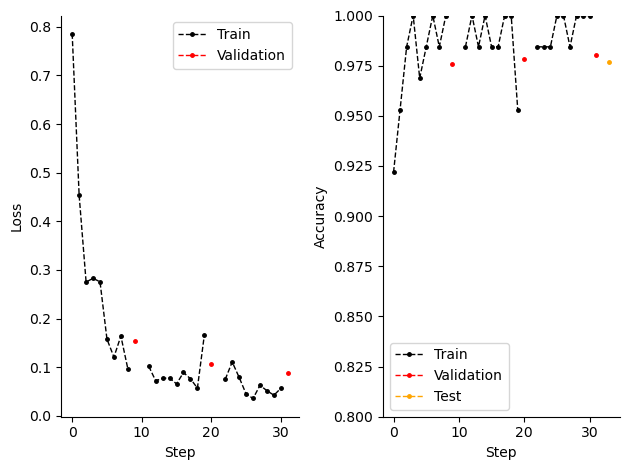

In [79]:
fig, axs = plt.subplots(1, 2)

plot_args = dict(linestyle="dashed", linewidth=1, style='.-', markersize=5)

run_history.plot(x="_step", y="train_loss_step", color="k", label="Train", ax=axs[0], **plot_args)
run_history.plot(
    x="_step",
    y="valid_loss",
    color="r",
    label="Validation",
    ax=axs[0],
    **plot_args
)
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Step")

run_history.plot(
    x="_step",
    y="train_metric_step",
    color="k",
    label="Train",
    ax=axs[1],
    **plot_args,
)
run_history.plot(
    x="_step",
    y="valid_metric",
    color="r",
    label="Validation",
    ax=axs[1],
    **plot_args,
)
run_history.plot(
    x="_step",
    y="test_metric",
    color="orange",
    label="Test",
    ax=axs[1],
    **plot_args,
)
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Step")
axs[1].set_ylim(0.8, 1)

sns.despine()
fig.tight_layout()
plt.show()

We can also retrieve the logs that were printed out to the terminal

In [108]:
logs = run.file("output.log").download(exist_ok=True).read().splitlines()

logs

['Start evaluation!',
 'GPU available: True (cuda), used: True',
 'TPU available: False, using: 0 TPU cores',
 'HPU available: False, using: 0 HPUs',
 'LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]',
 '',
 '  | Name              | Type                        | Params | Mode',
 '--------------------------------------------------------------------------',
 '0 | feature_extractor | HuggingfaceFeatureExtractor | 315 M  | eval',
 '1 | classifier        | MLP                         | 5.1 K  | train',
 '2 | loss_fn           | NLLLoss                     | 0      | train',
 '3 | train_metric      | MulticlassAccuracy          | 0      | train',
 '4 | valid_metric      | MulticlassAccuracy          | 0      | train',
 '5 | test_metric       | MulticlassAccuracy          | 0      | train',
 '--------------------------------------------------------------------------',
 '311 M     Trainable params',
 '4.2 M     Non-trainable params',
 '315 M     Total params',
 '1,261.775 Total estimated model par

### Model versioning

Model versioning is especially easy when the project is linked to Git, as W&B saves the git state and the commmand that was used to run the model.

For instance, the XLS-R model in Table 1 (see report) can be re-trained using the following:

```bash
git clone https://github.com/Neclow/mlops_project.git
git checkout -b "daily-music-9" ad179f780c71e76f571a74cc0120aa20daf2b854
python -m core.eval nort3160 facebook/wav2vec2-xls-r-300m speech --transform --device cuda:0 --max-duration 10
```

W&B also saves a snapshot of the environment that was used to perform the run. It can be retrieved using ```wandb.file```

In [106]:
requirements = run.file("requirements.txt").download(exist_ok=True).read().splitlines()

sorted(requirements)[:10]

['Brotli==1.1.0',
 'ConfigArgParse==1.7',
 'Cython==3.0.11',
 'Distance==0.1.3',
 'Django==4.2.15',
 'GitPython==3.1.43',
 'HyperPyYAML==1.2.2',
 'Jinja2==3.1.4',
 'Levenshtein==0.26.0',
 'Markdown==3.7']

### Retrieving artefacts

One can easily log model artifacts in the W&B cloud by setting ```log_model = True``` in ```WandbLogger```. For simplicity, we will log the checkpoint saved locally to restore our model.

In [158]:
# See core.train.py
eval_dir = "../data/eval"
project = "mlops_project_eval_nort3160"
save_dir = f"{eval_dir}/{project}"

ckpt = torch.load(f"{save_dir}/{run_id}/checkpoints/last.ckpt")

{k: v for (k, v) in ckpt.items() if not k in ["state_dict", "optimizer_states"]}

{'epoch': 2,
 'global_step': 1386,
 'pytorch-lightning_version': '2.4.0',
 'loops': {'fit_loop': {'state_dict': {},
   'epoch_loop.state_dict': {'_batches_that_stepped': 1386},
   'epoch_loop.batch_progress': {'total': {'ready': 1386,
     'completed': 1386,
     'started': 1386,
     'processed': 1386},
    'current': {'ready': 462,
     'completed': 462,
     'started': 462,
     'processed': 462},
    'is_last_batch': True},
   'epoch_loop.scheduler_progress': {'total': {'ready': 0, 'completed': 0},
    'current': {'ready': 0, 'completed': 0}},
   'epoch_loop.automatic_optimization.state_dict': {},
   'epoch_loop.automatic_optimization.optim_progress': {'optimizer': {'step': {'total': {'ready': 1386,
       'completed': 1386},
      'current': {'ready': 462, 'completed': 462}},
     'zero_grad': {'total': {'ready': 1386,
       'completed': 1386,
       'started': 1386},
      'current': {'ready': 462, 'completed': 462, 'started': 462}}}},
   'epoch_loop.manual_optimization.state_di

In [155]:
state_dict = ckpt["state_dict"]

my_cache_dir = "/home/common/speech_phylo/models"

if not os.path.isdir(my_cache_dir):
    my_cache_dir = None  # Or enter your cache dir here

feature_extractor = load_feature_extractor(
    run.config["model_id"], cache_dir=my_cache_dir, device="cuda:0"
)

lit_mlp = LightningMLP(
    feature_extractor=feature_extractor,
    num_classes=ckpt["hyper_parameters"]["num_classes"],
    loss_fn=ckpt["hyper_parameters"]["loss_fn"],
    lr=ckpt["hyper_parameters"]["lr"],
    weight_decay=ckpt["hyper_parameters"]["weight_decay"],
)

# We have restored our model
lit_mlp.load_state_dict(state_dict)

<All keys matched successfully>